Question-1: 

Design a proper connected sensor network that covers the area of the plant by using a
reasonable number of sensors. How many do we need to guarantee a connected sensor
network? Motivate your choice.

In [1]:
# This is done by using a Random Geometric Graph
#Reference: 
# 1. https://academic.oup.com/book/9064?login=true
# 2. https://arxiv.org/pdf/1207.2573: formulation for the radius

#https://dl.acm.org/doi/pdf/10.1145/958491.958496

In [2]:
# Import Libraries

from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Beginner Functions

In [3]:
# Essential Functions

# Function to calculate adjacency matrix
def calculate_adjacency_matrix(agent_locations, communication_range):
    num_agents = agent_locations.shape[1]
    adjacency_matrix = np.zeros((num_agents, num_agents), dtype=int)

    for i in range(num_agents):
        for j in range(num_agents):
            if i != j:  # to avoid self-loops
                distance = np.linalg.norm(agent_locations[:, i] - agent_locations[:, j])
                if distance <= communication_range:
                    adjacency_matrix[i, j] = 1

    return adjacency_matrix

# Function to check graph connectivity
def is_graph_connected(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    eigenvalues = np.linalg.eigvalsh(laplacian_matrix)
    zero_eigenvalues = np.sum(np.isclose(eigenvalues, 0))
    return zero_eigenvalues == 1

# Function to create transition matrix P
def generate_uniform_P(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    P = np.zeros((n, n), dtype=float)

    for i in range(n):
        neighbors = np.where(adjacency_matrix[i] == 1)[0]
        degree = len(neighbors)
        if degree > 0:
            P[i, neighbors] = 1.0 / degree  # Uniform distribution over neighbors
        # If no neighbors, row stays all zero (won't be used anyway)

    return P


Loop: Assuming that r was assumed and n was calculated accordingly

Is network connected? True


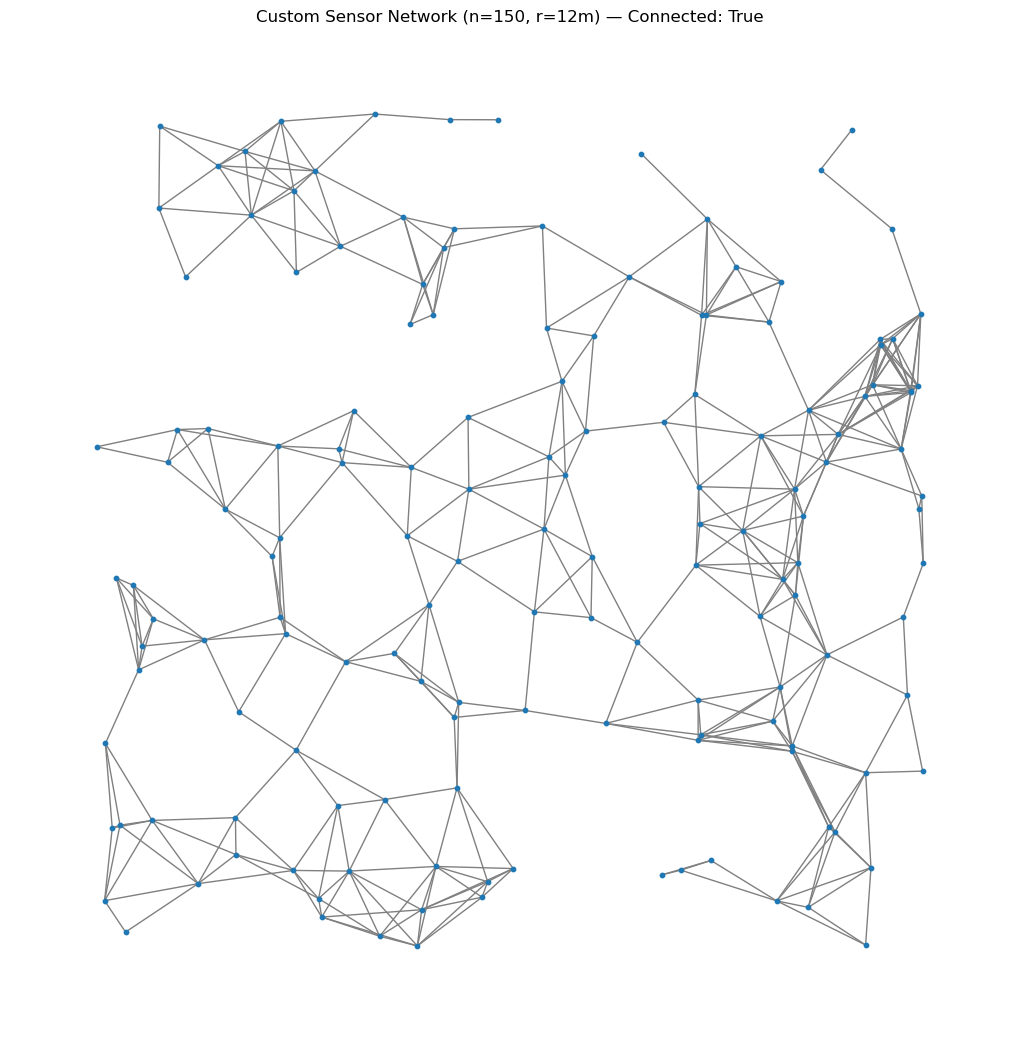

In [4]:
# === Parameters ===
n = 150
area_size = 100
r = 12

# === Generate sensor locations as [2, n] array ===
np.random.seed(45)
positions = np.random.uniform(0, area_size, (n, 2)).T  # shape: [2, n]

# === Calculate adjacency matrix and check connectivity ===
adj_matrix = calculate_adjacency_matrix(positions, r)
connected = is_graph_connected(adj_matrix)

# === Print result ===
print(f"Is network connected? {connected}")

# === Visualize using networkx ===
G = nx.from_numpy_array(adj_matrix)
pos_dict = {i: positions[:, i] for i in range(n)}

plt.figure(figsize=(10, 10))
nx.draw(G, pos=pos_dict, node_size=10, edge_color='gray')
plt.title(f"Custom Sensor Network (n={n}, r={r}m) — Connected: {connected}")
plt.axis('equal')
plt.grid(True)
plt.show()


Q2. Suppose the sensor network would like to compute the average value of the measurement data. In addition to a randomised gossip implementation, which will serve as a baseline method, implement the average consensus problem using the PDMM algorithm. Report the performance in terms of convergence speed and number of transmissions and compare this to the results obtained by the randomised gossip algorithm.

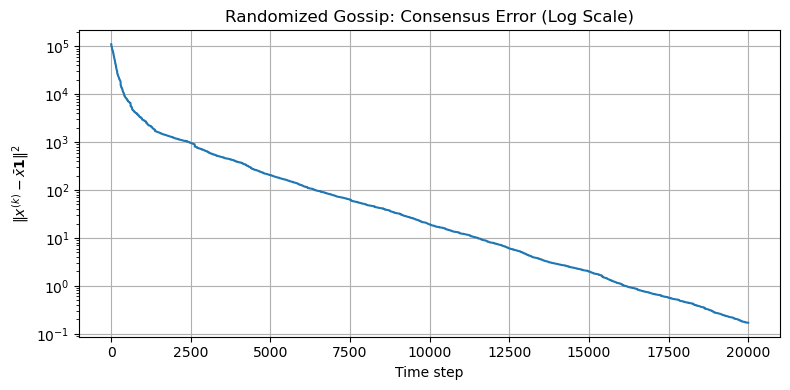

Final squared error: 0.1692927396240168
Final range: 48.641556210281294 to 48.79613089129316
Should converge to: 48.71333333333333


In [ ]:
#THIS WORKS!!

# === Randomized Gossip ===
def randomized_gossip(adj_matrix, x0, time_steps):
    n = len(x0)
    x = x0.copy().astype(float)
    avg = np.mean(x)
    avg_vec = avg * np.ones((n, 1))
    error_rg = []

    edges = np.array(np.transpose(np.where(np.triu(adj_matrix, 1) == 1)))
    for _ in range(time_steps):
        i, j = edges[np.random.randint(edges.shape[0])]
        x_ij_avg = 0.5 * (x[i] + x[j])
        x[i] = x_ij_avg
        x[j] = x_ij_avg
        error_rg.append(np.linalg.norm(x - avg_vec)**2)
    return error_rg, x

# === Setup ===
np.random.seed(45)
n = 150
area_size = 100
r = 20

positions = np.random.uniform(0, area_size, (2, n))
adj_matrix = calculate_adjacency_matrix(positions, r)

# Check connectivity (crude)
from scipy.sparse.csgraph import connected_components
if connected_components(adj_matrix)[0] > 1:
    raise ValueError("Graph is not connected!")

x0 = np.random.randint(0, 100, (n, 1))
time_steps = 20000

error_rg, x_final = randomized_gossip(adj_matrix, x0, time_steps)

# === Plot ===
plt.figure(figsize=(8, 4))
plt.semilogy(error_rg)
plt.xlabel("Time step")
plt.ylabel(r"$\|x^{(k)} - \bar{x}\mathbf{1}\|^2$")
plt.title("Randomized Gossip: Consensus Error (Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Final diagnostics
print("Final squared error:", error_rg[-1])
print("Final range:", x_final.min(), "to", x_final.max())
print("Should converge to:", np.mean(x0))


In [6]:
# Construct Expected Weight Matrix E[W]
P = generate_uniform_P(adj_matrix)
n = P.shape[0]
W_expected = np.zeros((n, n))
I = np.eye(n)

for i in range(n):
    for j in range(n):
        if P[i, j] > 0:
            v = np.zeros((n, 1))
            v[i] = 1
            v[j] = -1
            Wij = I - 0.5 * (v @ v.T)
            W_expected += (1 / n) * P[i, j] * Wij

print(W_expected)

[[0.99295597 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99300176 0.         ... 0.         0.         0.        ]
 [0.         0.         0.99224941 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99386408 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99288166 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99344807]]


PDMM-Nishita version: Average Consensus

In [7]:
# a = np.random.randint(0, 100, size=n)
# true_average = np.mean(a)

# adj_matrix_modified = adj_matrix.copy()
# adj_matrix_modified[adj_matrix_modified == 0] = -1

# x = a.astype(float).copy()
# z = {}  # duals z_{i|j}

# for i in G.nodes:
#     for j in G.neighbors(i):
#         z[(i, j)] = 0.0  # initialize duals to 0

# x_history = [x.copy()]
# error_history = [np.linalg.norm(x - true_average)]

# # === PDMM iterations ===
# for k in range(iterations):
#     x_new = x.copy()

#     # Step 1: primal update (from Jelena's slide)
#     for i in G.nodes:
#         neighbors = list(G.neighbors(i))
#         d = len(neighbors)
#         sum_z = sum(z[(i, j)] for j in neighbors)
#         x_new[i] = (a[i] - sum_z) / (1 + c * d)

#     # Step 2: auxiliary y_{i|j} update
#     y = {}
#     for i in G.nodes:
#         for j in G.neighbors(i):
#             y[(i, j)] = z[(i, j)] + 2 * c * x_new[i]

#     # Step 3: dual flip step (from PDMM slide box)
#     for i in G.nodes:
#         for j in G.neighbors(i):
#             z[(j, i)] = -y[(i, j)]

#     x = x_new.copy()
#     x_history.append(x.copy())
#     error_history.append(np.linalg.norm(x - true_average))

# # === Plot convergence ===
# plt.figure(figsize=(8, 4))
# plt.semilogy(error_history, marker='o')
# plt.xlabel("Iteration")
# plt.ylabel("Log L2 error to average")
# plt.title("PDMM Distributed Averaging Error (Slide-Accurate)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # === Final results ===
# print("Final consensus values (first 10):", np.round(x[:10], 4))
# print("True average:", round(true_average, 4))

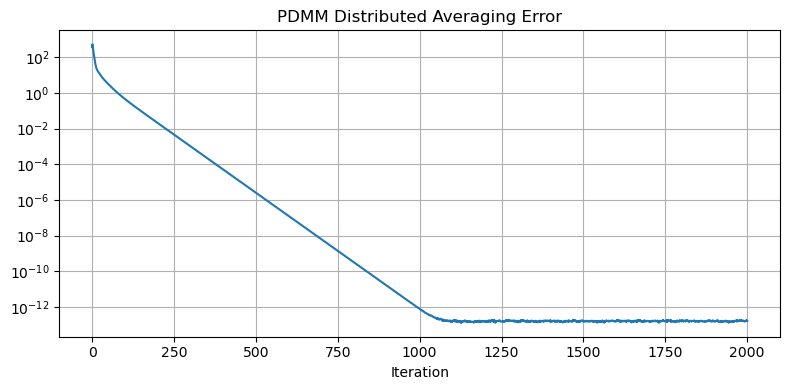

Final error: 1.6373346940387866e-13
Final consensus values : [52.4333 52.4333 52.4333 52.4333 52.4333 52.4333 52.4333 52.4333 52.4333
 52.4333]
True average: 52.4333


In [8]:
# Average Consensus Using PDMM

adj_matrix_modified = adj_matrix.copy()
adj_matrix_modified[adj_matrix_modified == 0] = -1
n = G.number_of_nodes()
a = np.random.randint(0, 100, size=n)       #startn node vals
true_average = np.mean(a)
c = 1.0                                       
iterations = 2000


x = a.astype(float).copy()                   
z = {}                                       

for i in G.nodes:
    for j in G.neighbors(i):
        z[(i, j)] = 0.0                      #makign duals=0

x_history = [x.copy()]
error_ac = [np.linalg.norm(x - true_average)]

for k in range(iterations):
    x_new = x.copy()

    #primal update from slides that jelena told 
    for i in G.nodes:
        neighbors = list(G.neighbors(i))
        d = len(neighbors)
        sum_z = sum(z[(i, j)] for j in neighbors)
        x_new[i] = (a[i] - sum_z) / (1 + c * d)

    #y partial update step
    y = {}
    for i in G.nodes:
        for j in G.neighbors(i):
            y[(i, j)] = z[(i, j)] + 2 * c * x_new[i]

    #god knows why we do this step, but in the sldie(flip steps)
    for i in G.nodes:
        for j in G.neighbors(i):
            z[(j, i)] = -y[(i, j)]

    x = x_new.copy()
    x_history.append(x.copy())
    error_ac.append(np.linalg.norm(x - true_average))


plt.figure(figsize=(8, 4))
plt.semilogy(error_ac)
plt.xlabel("Iteration")
# plt.ylabel(r"$\|x^{(k)} - \bar{a}\mathbf{1}\|_2$")
plt.title("PDMM Distributed Averaging Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final results ===
print("Final error:", error_ac[-1])
print("Final consensus values :", np.round(x[:10], 4))
print("True average:", round(true_average, 4))

Q3. Suppose the sensor network would like to compute the median of the measurement
data. Implement the median consensus problem using the PDMM algorithm.

In [9]:
# BROKEN MEDIAN CONSENSUS CODE
# only works with modified adj matrix, uses normal ascent instead of median PDMM ascent

# # G = nx.from_numpy_array(adj_matrix_modified)
# # Median Consensus
# neighbors = {i: list(G.neighbors(i)) for i in G}
# degrees = np.array([len(neighbors[i]) for i in range(n)])

# # Set parameters
# c = 1.0             
# iters = 2000            

# # Initial private data and true median
# np.random.seed(45)
# s = np.random.randn(n)                     # private scalar at each node
# true_med = np.median(s)

# # Initialize primal and dual
# x = s.copy()                               # start at private values (or zeros)
# z = { (i,j): 0.0 for i in G for j in neighbors[i] }

# error_hist = []

# for k in range(iters):
#     x_new = np.zeros_like(x)

#     # 1) Primal (median‐prox) update at each node
#     for i in range(n):
#         di = degrees[i]
#         if di == 0:
#             x_new[i] = s[i]
#             continue
#         # compute v_i = (1/di) sum_j ( x_j - z_{i|j}/c )
#         total = 0.0
#         for j in neighbors[i]:
#             total += x[j] - z[(i,j)]/c
#         v = total / di

#         # proximal‐L1 step: lam = 1/(c * di)
#         lam = 1.0 / (c * di)
#         u = v - s[i]
#         x_new[i] = s[i] + np.sign(u) * np.maximum(np.abs(u) - lam, 0.0)

#     # 2) Dual update on each directed edge
#     old_z = z.copy() # Use a copy to avoid using partially updated values in the same iteration
#     for i in range(n):
#         for j in neighbors[i]:
#             z[(j,i)] = 0.5 * old_z[(j,i)] + 0.5 * (old_z[(i,j)] + 2 * c * x_new[i])
    
#     x = x_new

#     # record consensus error
#     error_hist.append(np.linalg.norm(x - true_med))

# # Plot convergence
# plt.semilogy(error_hist)
# plt.xlabel('Iteration')
# plt.ylabel('||x - true_median||')
# plt.title('PDMM Median Consensus Convergence')
# plt.grid(True)
# plt.show()

# print(f"Final node estimates (first 10): {x[:10]}")
# print(f"True median: {true_med}")

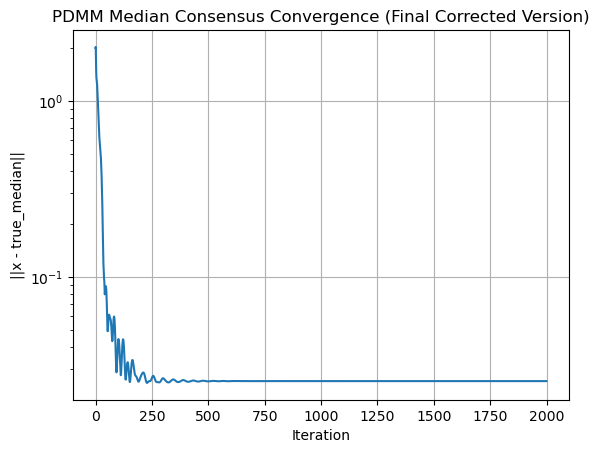

Final error: 0.025644224481428647
Final node estimates (first 10): [-0.13628862 -0.13628862 -0.13628862 -0.13628862 -0.13628862 -0.13628862
 -0.13628862 -0.13628862 -0.13628862 -0.13628862]
True median: -0.13419477811561714


In [ ]:
# --- FINAL, FULLY CORRECTED PDMM MEDIAN CONSENSUS ---

# Use the original 0/1 adjacency matrix to create the graph
G = nx.from_numpy_array(adj_matrix)
n = G.number_of_nodes()
neighbors = {i: list(G.neighbors(i)) for i in G.nodes()}
degrees = np.array([len(neighbors[i]) for i in range(n)])

# Set parameters
c = 1.0
iters = 2000

# Initial private data and true median
np.random.seed(45)
s = np.random.randn(n)  # private scalar at each node
true_med = np.median(s)

# 1) Initialization
x = s.copy()
# Duals z_{i|j} are associated with node i's view of the edge (i,j)
z = {(i, j): 0.0 for i in G for j in neighbors[i]}

error_mc = []

# --- PDMM Iterations ---
for k in range(iters):
    x_new = np.zeros_like(x)

    # --- CORRECTED PRIMAL UPDATE ---
    # Implements the three-case function from Eq. (4) with the correct A_ij sign convention
    for i in range(n):
        di = degrees[i]
        if di == 0:
            x_new[i] = s[i]
            continue
        
        # This sum now correctly includes the A_ij sign
        sum_z = sum((1 if i < j else -1) * z[(i, j)] for j in neighbors[i])

        # Define the interval boundaries from Algorithm 1
        bound_1 = (1 - sum_z) / (c * di)
        bound_2 = (-1 - sum_z) / (c * di)

        lower_bound = min(bound_1, bound_2)
        upper_bound = max(bound_1, bound_2)
        
        # Apply the three-case clipping rule
        if s[i] < lower_bound:
            x_new[i] = lower_bound
        elif s[i] > upper_bound:
            x_new[i] = upper_bound
        else:
            x_new[i] = s[i]

    # --- CORRECTED DUAL UPDATE ---
    # Implements the Averaged PDMM update from Eq. (5) with the correct A_ij sign convention
    old_z = z.copy() 
    for i in range(n):
        for j in neighbors[i]:
            # Define A_ij based on the paper's convention
            A_ij = 1 if i < j else -1
            
            # Update the dual variable at node j for the edge coming from i
            # This implements z_{j|i}^{(t+1)} = (1-θ)z_{j|i} + θ * y_{i|j}, with θ=1/2
            # and y_{i|j} = z_{i|j} + 2c*A_ij*x_i
            # Note: The update for z[(j, i)] depends on x_new[i]
            z[(j, i)] = 0.5 * old_z[(j, i)] + 0.5 * (old_z[(i, j)] + 2 * c * A_ij * x_new[i])
            
    x = x_new
    error_mc.append(np.linalg.norm(x - true_med))

# --- Plot convergence and show results ---
plt.semilogy(error_mc)
plt.xlabel('Iteration')
plt.ylabel('||x - true_median||')
plt.title('PDMM Median Consensus Convergence')
plt.grid(True)
plt.show()

print(f"Final error: {error_mc[-1]}")
print(f"Final node estimates (first 10): {x[:10]}")
print(f"True median: {true_med}")

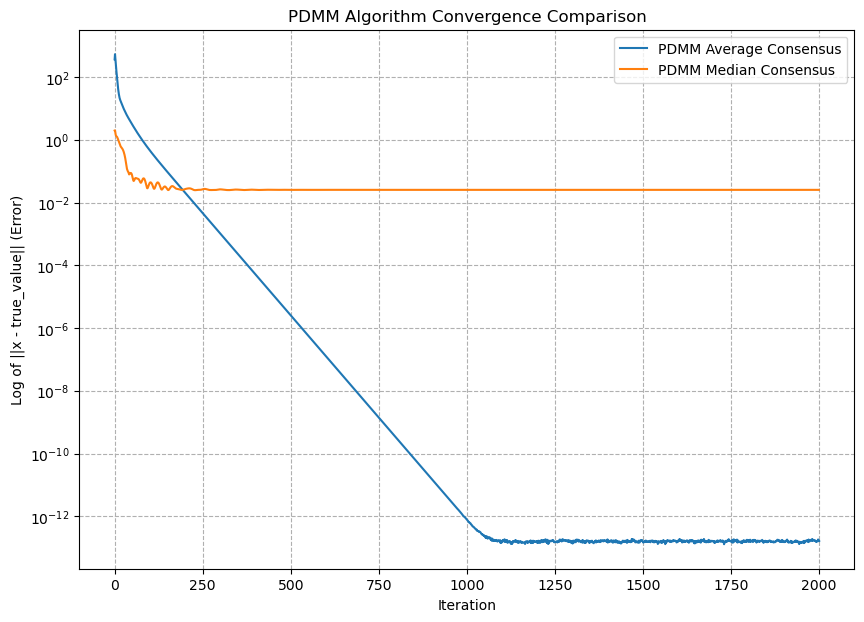

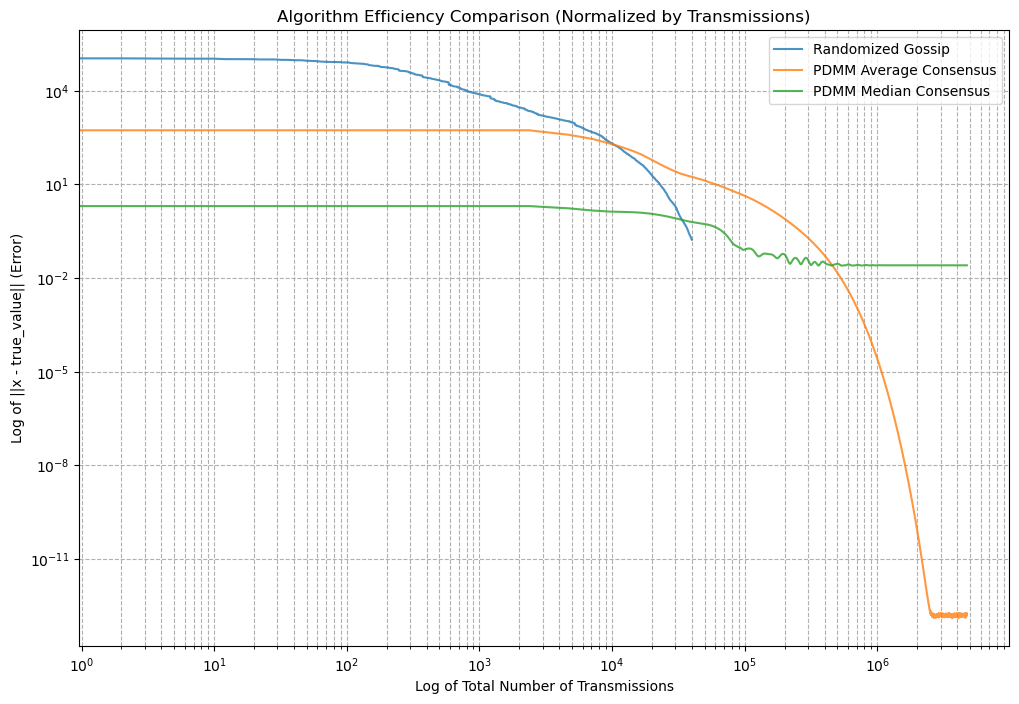

In [14]:
# --- PLOT 1: COMPARING PDMM ALGORITHMS ---

plt.figure(figsize=(10, 7))

# Only plot the two PDMM error histories
plt.semilogy(error_ac, label='PDMM Average Consensus')
plt.semilogy(error_mc, label='PDMM Median Consensus')

plt.title('PDMM Algorithm Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Log of ||x - true_value|| (Error)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
# --- PLOT 2: NORMALIZED BY NUMBER OF TRANSMISSIONS ---

# Calculate the number of edges in the graph
num_edges = G.number_of_edges()

# Create the x-axis arrays for transmissions
transmissions_rg = np.arange(len(error_rg)) * 2  # 2 transmissions per gossip iteration
transmissions_pdmm_ac = np.arange(len(error_ac)) * (2 * num_edges) # 2*|E| transmissions per PDMM iteration
transmissions_pdmm_mc = np.arange(len(error_mc)) * (2 * num_edges)

plt.figure(figsize=(12, 8))

# Plot error vs. number of transmissions
# Use a log-log plot here to handle the very large x-axis range for transmissions
plt.loglog(transmissions_rg, error_rg, label='Randomized Gossip', alpha=0.8)
plt.loglog(transmissions_pdmm_ac, error_ac, label='PDMM Average Consensus', alpha=0.8)
plt.loglog(transmissions_pdmm_mc, error_mc, label='PDMM Median Consensus', alpha=0.8)

plt.title('Algorithm Efficiency Comparison (Normalized by Transmissions)')
plt.xlabel('Log of Total Number of Transmissions')
plt.ylabel('Log of ||x - true_value|| (Error)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()